In [1]:
from dpks.quant_matrix import QuantMatrix

import pandas as pd
import numpy as np

In [2]:
design_matrix = pd.read_csv(
    "../tests/input_files/design_sepsis.tsv",
    sep="\t"
)

In [3]:
design_matrix = design_matrix.sort_values("group", ascending=False).reset_index(drop=True)

In [4]:
design_matrix['sample_num'] = design_matrix.index.values

Now, we simulate 3 groups in the data so we can perform multiple rounds of explanations

In [5]:
design_matrix['group'] = np.where(
    design_matrix['sample_num'] < 50, 3, design_matrix['group']
)

In [6]:
design_matrix['group'].value_counts()

group
1    74
2    73
3    50
Name: count, dtype: int64

In [7]:
qm = QuantMatrix(
    quantification_file="../tests/input_files/data_sepsis.tsv",
    design_matrix_file=design_matrix
).filter()

In [8]:
quantified_data = (
    qm.normalize(
        method="mean",
        use_rt_sliding_window_filter=True,
        rt_unit="second",
        stride=5,
        minimum_data_points=200,
    )
)

In [9]:
quantified_data = (
    quantified_data.quantify(
        method="maxlfq",
        threads=4,
        #top_n=5
    )
    .impute(
        method="uniform_percentile",
        percentile=0.05
    )
    .compare(
        method="linregress",
        min_samples_per_group=2,
        comparisons=[(2, 1), (3, 1)]
    )
)

/home/aaron/projects/dpks/DPKS/dpks/quantification.py:275: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  grouping = mask_group(groupings[group_idx])


In [10]:
import xgboost

clf = xgboost.XGBClassifier(
    max_depth=2,
    #subsample=0.5,
    reg_lambda=2,
    objective="binary:logistic",
    seed=42
)

In [11]:
quantified_data = quantified_data.explain(
    clf,
    comparisons=[(2, 1), (3, 1)],
    n_iterations=10,
    downsample_background=True
)

In [13]:
quantified_data = quantified_data.annotate()

In [15]:
quantified_data.row_annotations.sort_values("MeanImportance2-1", ascending=False)

,Protein,DEScore2-1,Group2Mean,Group1Mean,Group2Stdev,Group1Stdev,Log2FoldChange2-1,PValue2-1,Group2RepCounts,Group1RepCounts,...,Log2FoldChange3-1,PValue3-1,Group3RepCounts,CorrectedPValue3-1,-Log10CorrectedPValue3-1,MeanImportance2-1,MeanRank2-1,MeanImportance3-1,MeanRank3-1,Gene
78,P05362,0.897970,20.044225,18.470762,1.233650,0.770893,1.573463,3.132890e-16,73,74,...,1.451074,1.220863e-18,50,1.379575e-16,15.860255,0.489644,4.20,0.123357,176.50,ICAM1
151,P16070,1.056318,20.535027,19.460412,0.609436,0.539891,1.074615,1.761939e-21,73,74,...,1.037115,7.571437e-17,50,4.277862e-15,14.368773,0.414304,5.80,0.018648,124.70,CD44
147,P08571,1.045212,21.107079,20.104399,0.615821,0.449466,1.002680,2.152132e-21,73,74,...,1.033181,4.368335e-18,50,3.702164e-16,15.431544,0.362852,6.70,0.036370,67.95,CD14
338,Q06033,0.612527,22.366831,21.786368,0.476341,0.409579,0.580464,7.473925e-13,73,74,...,0.397065,2.676311e-07,50,1.620124e-06,5.790452,0.315875,9.50,0.000000,290.00,ITIH3
459,P80188,1.029217,20.316739,17.840397,1.213003,2.137889,2.476342,1.465579e-14,73,74,...,2.809937,4.068578e-14,50,1.060960e-12,11.974301,0.220844,40.45,0.470006,5.70,LCN2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,P28072,0.223531,15.647090,14.969354,2.026160,2.110968,0.677737,5.052426e-02,73,74,...,0.163972,6.341254e-01,50,4.683410e-01,0.329438,0.000000,297.25,0.000000,290.00,PSMB6
213,P02655,0.074070,23.756954,23.552444,1.100918,0.677918,0.204510,1.794778e-01,73,74,...,0.029736,8.294893e-01,50,5.481421e-01,0.261107,0.000000,297.25,0.000738,262.85,APOC2
212,P05543,0.179881,20.271919,19.801139,1.119047,0.990934,0.470779,8.148517e-03,73,74,...,0.425511,2.881976e-02,50,4.322964e-02,1.364218,0.000000,297.25,0.000000,290.00,SERPINA7
211,P35749,0.022422,14.421859,14.481786,0.642077,0.609399,-0.059927,5.651676e-01,73,74,...,-0.124852,2.153973e-01,50,2.108304e-01,0.676067,0.000000,297.25,0.000000,290.00,MYH11


In [14]:
quantified_data.row_annotations['-log(p)'] = - np.log(quantified_data.row_annotations['CorrectedPValue2-1'])

In [15]:
import seaborn as sns

<Axes: xlabel='Log2FoldChange2-1', ylabel='-log(p)'>

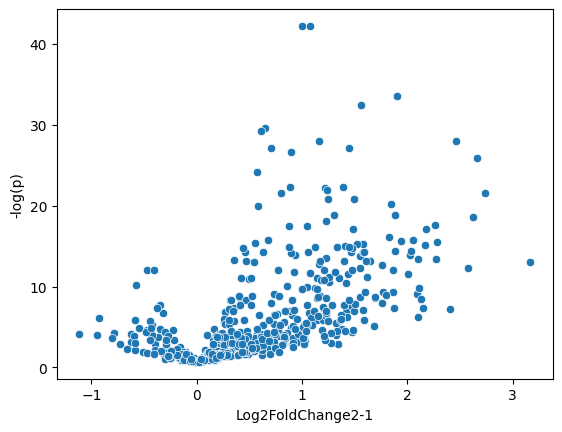

In [16]:
sns.scatterplot(
    data=quantified_data.row_annotations,
    x="Log2FoldChange2-1",
    y="-log(p)"
)

In [17]:
quantified_data.row_annotations['InverseRank2-1'] = 1 / quantified_data.row_annotations['MeanRank2-1']

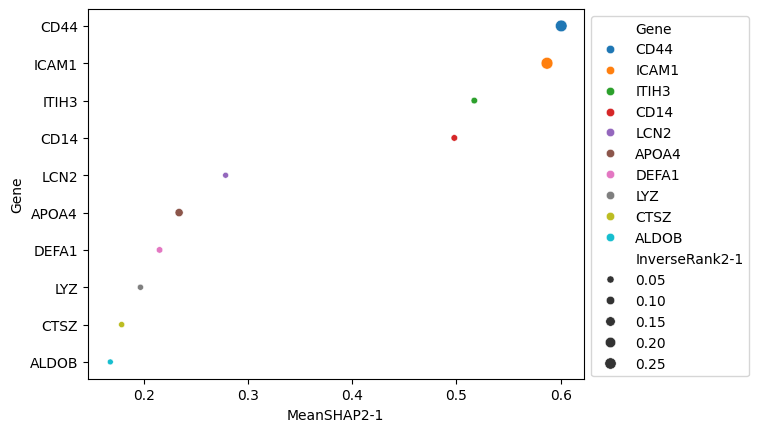

In [18]:
ax = sns.scatterplot(
    data=quantified_data.row_annotations.sort_values("MeanSHAP2-1", ascending=False).head(10),
    x="MeanSHAP2-1",
    y="Gene",
    hue="Gene",
    size="InverseRank2-1",
)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

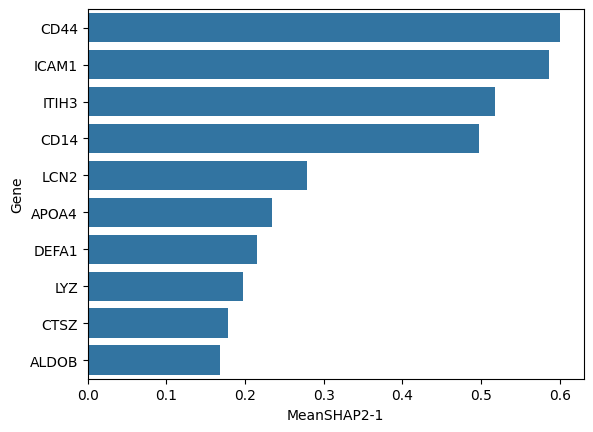

In [19]:
ax = sns.barplot(
    data=quantified_data.row_annotations.sort_values("MeanSHAP2-1", ascending=False).head(10),
    x="MeanSHAP2-1",
    y="Gene",
    hue_order="Gene",
)

<Axes: xlabel='MeanSHAP2-1', ylabel='-log(p)'>

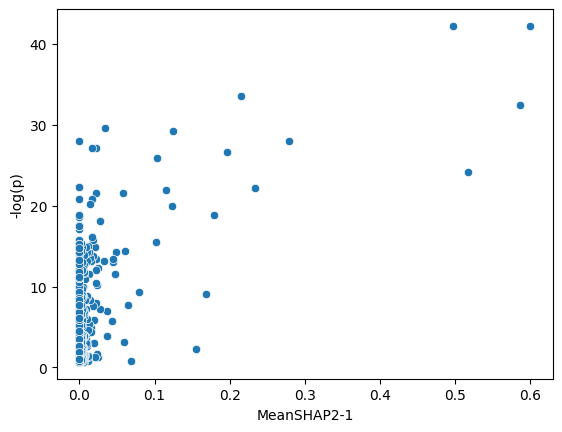

In [20]:
sns.scatterplot(
    data=quantified_data.row_annotations.sort_values("MeanSHAP2-1", ascending=False),
    y="-log(p)",
    x="MeanSHAP2-1",
)